In [1]:
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import paste
import scanpy as sc
import anndata
from sklearn.decomposition import NMF
import scanorama
import scipy
import os

style.use('seaborn-dark')
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 

# Define Functions

In [2]:
def rotate_spots(grid,spots,theta=0,translation=0,center_correction=0,figsize=(5,5),plot=True):
    grid = grid.copy() + center_correction
    spots = spots.copy() + center_correction
    R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    rotated_spots = np.array([R.dot(spots[i]) for i in range(len(spots))])
    rotated_spots += translation

    new_spots = grid[np.argmin(scipy.spatial.distance.cdist(rotated_spots,grid),axis=1)]

    grid -= center_correction
    spots -= center_correction
    rotated_spots -= center_correction
    new_spots -= center_correction

    seen = {}
    mapping = []
    for i in range(len(new_spots)):
        if tuple(new_spots[i]) in seen: continue
        seen[tuple(new_spots[i])] = 1
        mapping.append(i)

    if plot:
        fig = plt.figure(figsize=figsize)
        sns.scatterplot(x = grid[:,0],y = grid[:,1],linewidth=0,s=100, marker=".",alpha=0.2,color='blue')
        sns.scatterplot(x = rotated_spots[:,0],y = rotated_spots[:,1],linewidth=0,s=100, marker=".",color='red')
        sns.scatterplot(x = new_spots[:,0],y = new_spots[:,1],linewidth=0,s=100, marker=".",color='green')
        plt.show()

    return new_spots,mapping

def simulate_spatial(adata, rotation_angle):
    adata_sim = adata.copy()

    grid_size = 40
    layer_grid = np.array([[x,y] for x in range(grid_size) for y in range(grid_size)])
    new_spots, mappings = rotate_spots(layer_grid, adata.obsm['spatial'], center_correction=-15, 
                                       theta= rotation_angle, plot = False)
    adata_sim.obsm['spatial'] = new_spots
    return adata_sim[mappings, :], mappings

In [3]:
def plot1(adata, title = None):
        """
        Visualizes distribution of spot coordinates
        """
        plt.figure(figsize= (5, 5))
        x = adata.obsm['spatial'][:, 0]
        y = adata.obsm['spatial'][:, 1]
        x = x - np.mean(x)
        y = y - np.mean(y)
        ax = sns.scatterplot(x, y, color = '#1f77b4')
        ax.set(xlim=(-17, 17), ylim=(-17,17))
        ax.set_xlabel('x', fontsize=14)
        ax.set_ylabel('y', fontsize=14)
        ax.set_facecolor('white')
        ax.patch.set_edgecolor('black')
        ax.patch.set_linewidth('1')  
        if title == None:
            # plt.title('Visualization of Tissue Layer')
            a = 1
        else:
            plt.title(title)
        plt.tick_params(labelleft=False, labelbottom=False)
        return plt

# Generate Plots

In [4]:
def load_breast_layer(path):
    X = pd.read_csv(path, index_col= 0)
    coor = []
    for c in X.index:
        coor.append([float(x) for x in c.split('x')])
    adata = anndata.AnnData(X = X)
    adata.obsm['spatial'] = np.array(coor)
    return adata

In [5]:
layer1_path = "../data/Stahl-BC/stahl_bc_slice1.csv" 
layer2_path = "../data/Stahl-BC/stahl_bc_slice2.csv"
layer3_path = "../data/Stahl-BC/stahl_bc_slice3.csv"
layer4_path = "../data/Stahl-BC/stahl_bc_slice4.csv"

adata_layer_1 = load_breast_layer(layer1_path)
adata_layer_2 = load_breast_layer(layer2_path)
adata_layer_3 = load_breast_layer(layer3_path)
adata_layer_4 = load_breast_layer(layer4_path)

slices = {
    "SliceA" : adata_layer_1,
    "SliceB" : adata_layer_2,
    "SliceC" : adata_layer_3,
    "SliceD" : adata_layer_4
}

/home/max/Programs/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/max/Programs/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/max/Programs/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/max/Pro

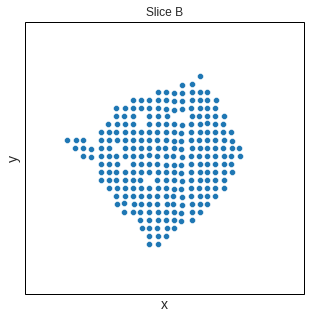

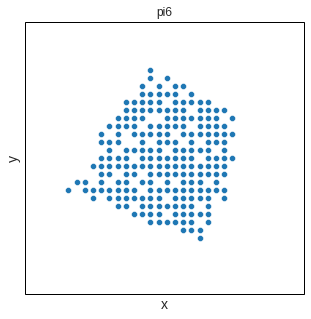

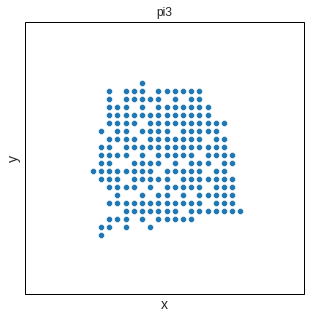

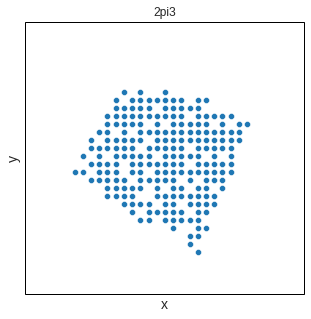

In [7]:
plots = []
plot1(adata_layer_2, title = 'Slice B')
# plt.savefig('original.png', dpi = 300, bbox_inches = "tight")
sim_layers = []
maps = []
theta_angles = [math.pi/6, math.pi*2/6, math.pi*4/6]
for i in range(3):
    adata_layer_sim_spatial, mappings = simulate_spatial(adata_layer_2, theta_angles[i])
    sim_layers.append(adata_layer_sim_spatial)
    maps.append(mappings)
for sim, t in zip(sim_layers, ['pi6', 'pi3', '2pi3']):
    plot1(sim, title = t)
    # plt.savefig(t + '.png', dpi = 300, bbox_inches = "tight")